In [1]:
%pip install --upgrade keras

In [2]:
 %pip install torch torchvision torchaudio

In [3]:
%pip install scikit-learn pandas matplotlib transformers -U

In [4]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.2.1


In [5]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [ ]:
# Модель №4

In [13]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
model_bert = AutoModel.from_pretrained("google-bert/bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [14]:
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

['[CLS]',
 'По',
 'факт',
 '##у',
 'по',
 '##жар',
 '##а',
 'на',
 'заводе',
 'в',
 'Ю',
 '##гр',
 '##е',
 'за',
 '##ведено',
 'дело',
 '[SEP]']

In [15]:
text = data.loc[4, 'title']
text_ids = tokenizer.encode(text, add_special_tokens=True,
                            return_tensors='pt')
output = model_bert(text_ids, output_attentions=False)

In [16]:
class bert_wrapper(keras.Model):
    def __init__(self, model_bert, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model_bert = keras.layers.TorchModuleWrapper(model_bert)

    def call(self, inputs):
        x = self.model_bert(inputs)
        return x[0]

In [18]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [19]:
model_bert = AutoModel.from_pretrained('google-bert/bert-base-multilingual-cased')

In [20]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = bert_wrapper(model_bert)(input_word_ids)
# берем только самый первый вектор (CLS токен)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-5,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [21]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [23]:
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=5) # уменьшаю кол-во эпох

Epoch 1/5


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:588: UserWarning: Gradients do not exist for variables ['variable_794', 'variable_795'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 3528s 24s/step - accuracy: 0.0870 - loss: 2.8866 - rec_prec: 0.0026 - val_accuracy: 0.2581 - val_loss: 2.5957 - val_rec_prec: 0.0323
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3493s 24s/step - accuracy: 0.2857 - loss: 2.2640 - rec_prec: 0.0585 - val_accuracy: 0.1935 - val_loss: 2.3195 - val_rec_prec: 0.0000e+00
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3453s 24s/step - accuracy: 0.6701 - loss: 1.1237 - rec_prec: 0.5340 - val_accuracy: 0.4194 - val_loss: 1.7242 - val_rec_prec: 0.2258
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3457s 24s/step - accuracy: 0.8398 - loss: 0.4908 - rec_prec: 0.8827 - val_accuracy: 0.3226 - val_loss: 2.6457 - val_rec_prec: 0.1613
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3442s 24s/step - accuracy: 0.9595 - loss: 0.1550 - rec_prec: 0.9907 - val_accuracy: 0.4839 - val_loss: 2.2641 - val_rec_prec: 0.1613


dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


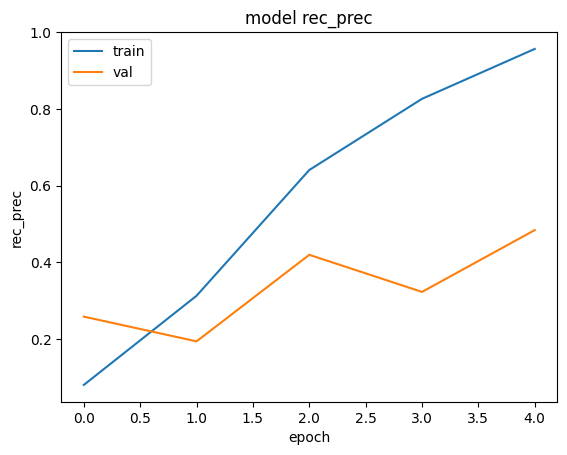

In [24]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
from sklearn.metrics import classification_report
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step
                   precision    recall  f1-score   support

             Крым       0.00      0.00      0.00         0
              Дом       0.00      0.00      0.00         2
         Ценности       0.67      1.00      0.80         2
         Культура       0.20      0.33      0.25         3
          Легпром       1.00      1.00      1.00         1
       Библиотека       0.00      0.00      0.00         0
           Бизнес       0.00      0.00      0.00         2
  Наука и техника       0.00      0.00      0.00         3
Силовые структуры       1.00      0.50      0.67         2
           Россия       0.00      0.00      0.00         2
   Интернет и СМИ       0.00      0.00      0.00         2
      Бывший СССР       0.50      1.00      0.67         3
            Спорт       1.00      1.00      1.00         2
   69-я параллель       1.00      1.00      1.00         1
              Мир       0.00      0.00      0.00         1
        Экономика 